#### Import the Necessary Python Packages

In [2]:
%matplotlib inline
import pandas
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

#### Define the MHLogit function. The Bayesian analysis here is carried out via the Metropolis Hastings Algorithm. The proposal distribution for Beta is assumed to be Multivariate Normal centered on the current value of Beta, and covaraince matrix B_tilda from the Normal Probit model. This is different from R's MCMCLogit, but shouldn't really impact the Metropolis Hastings outcome (might need to run this implementation longer for convergence)

In [3]:
def LogitLogLikelihood(y,p):
    # Log Likelihood
    loglikelihood = 0.0;
    # This loop is parallelizable
    for i in range(0,len(y)):
        loglikelihood = loglikelihood + y[i]*np.log(p[i]) + (1 - y[i])*np.log(1 - p[i])
    return loglikelihood.flatten().tolist()[0][0]

def MHLogit(X, y, prior_beta_mu, prior_beta_cov, num_iter, num_burnin_iter):
    from numpy.random import multivariate_normal as npmvnrand
    from scipy.stats import multivariate_normal as scipymvn

    Xmat = np.matrix(X) 
    yvec = np.transpose(np.matrix(y)) # Column Vector
    prior_beta_mu_vec = np.transpose(np.matrix(prior_beta_mu))
    prior_beta_cov_mat = np.matrix(prior_beta_cov)

    # Initialize beta to the OLS estimate of the Normal Linear Model
    # These computations do not change during the course of the Gibbs iterations
    beta = np.linalg.inv((Xmat.T)*Xmat)*(Xmat.T)*yvec
    B_tilda = np.linalg.inv(np.linalg.inv(prior_beta_cov_mat) + ((Xmat.T)*Xmat))
    
    coeffs = np.zeros(shape=(num_iter-num_burnin_iter,len(beta)))
    coefindx = 0
    
    arg = Xmat * beta;
    p = 1.0 / (1.0 + np.exp(-arg));
    loglikelihood = LogitLogLikelihood(yvec,p)
    logprior = scipymvn.logpdf(x=beta.flatten(),
                   mean=np.array(prior_beta_mu_vec).flatten(),cov=prior_beta_cov_mat)
    logposterior_curr = loglikelihood + logprior
    num_accepts = 0

    # Begin the Metropolis Hastings iterations
    # The outer loop will be used in the driver
    for ite in range(0,num_iter):
        # The inner loop can parellized via PL/Python UDF calls from the driver
        if (ite%500 == 0):
            print ite

        beta_can = np.transpose(
            npmvnrand(mean=np.array(beta).flatten(),cov=B_tilda,size =1)
        )
        
        arg = Xmat * beta_can;
        p = 1.0 / (1.0 + np.exp(-arg));
        loglikelihood = LogitLogLikelihood(yvec,p)
        # log prior
        logprior = scipymvn.logpdf(x=beta_can.flatten(),
                       mean=np.array(prior_beta_mu_vec).flatten(),cov=prior_beta_cov_mat)
        logposterior_can = loglikelihood + logprior
        ratio =np.exp(logposterior_can - logposterior_curr)
        
        if (np.random.rand() < ratio):
            beta = beta_can
            logposterior_curr = logposterior_can
            num_accepts = num_accepts+1

        if (ite >= num_burnin_iter):
            coeffs[coefindx,:] = beta.T
            coefindx = coefindx + 1
    print num_accepts
    return coeffs

#### Now let us read in a sample data set. We will use the lung cancer remission data set found here:
####http://www.ats.ucla.edu/stat/stata/dae/melogit.htm
#### We will first build a global model to predict lung cancer remission from tumorsize, co2, pain, wound, mobility, ntumors, nmorphine, lungcapacity, age, and BMI. For this model, we will use a Normal prior with zero mean and identity co-variance matrix for the Betas. The dataset will be standardized prior to fitting the model

In [4]:
from sklearn.preprocessing import StandardScaler
# Let us now test the logit MH model
df = pandas.read_csv('/Users/gmuralidhar/Projects/BayesianAnalysis/GibbsProbit/lung_cancer_remission.csv')
X = np.matrix(
        zip(
            np.array(df.tumorsize),
            np.array(df.co2),
            np.array(df.pain),
            np.array(df.wound),
            np.array(df.mobility),
            np.array(df.ntumors),
            np.array(df.nmorphine),
            np.array(df.lungcapacity),
            np.array(df.Age),
            np.array(df.BMI)
        )
    )
y = np.array(df.remission)
print type(X)
print X.shape
print type(y)
print y.shape
X_std = np.matrix(StandardScaler().fit_transform(X))
X_std = np.append(np.ones(shape=(X_std.shape[0],1)), X_std, axis = 1) # For the intercept term
print type(X_std)
print X_std.shape

<class 'numpy.matrixlib.defmatrix.matrix'>
(8525, 10)
<type 'numpy.ndarray'>
(8525,)
<class 'numpy.matrixlib.defmatrix.matrix'>
(8525, 11)


#### Call the Metropolis Hastings Logit function

In [5]:
coeffs = MHLogit(
            X=X_std, 
            y=y, 
            prior_beta_mu=np.zeros(X_std.shape[1]), 
            prior_beta_cov=np.identity(X_std.shape[1]), 
            num_iter=3000, 
            num_burnin_iter=300
         )

0
500
1000
1500
2000
2500
1442


#### Plot the coefficient trace

(2700, 11)
[ -9.38034381e-01   5.27559121e-02  -8.24042833e-02   2.16981587e-02
  -8.13012807e-04   1.85823045e-01  -1.31779134e-01   1.16539258e-01
   7.53448837e-02  -2.83351977e-01  -1.30955954e-02]


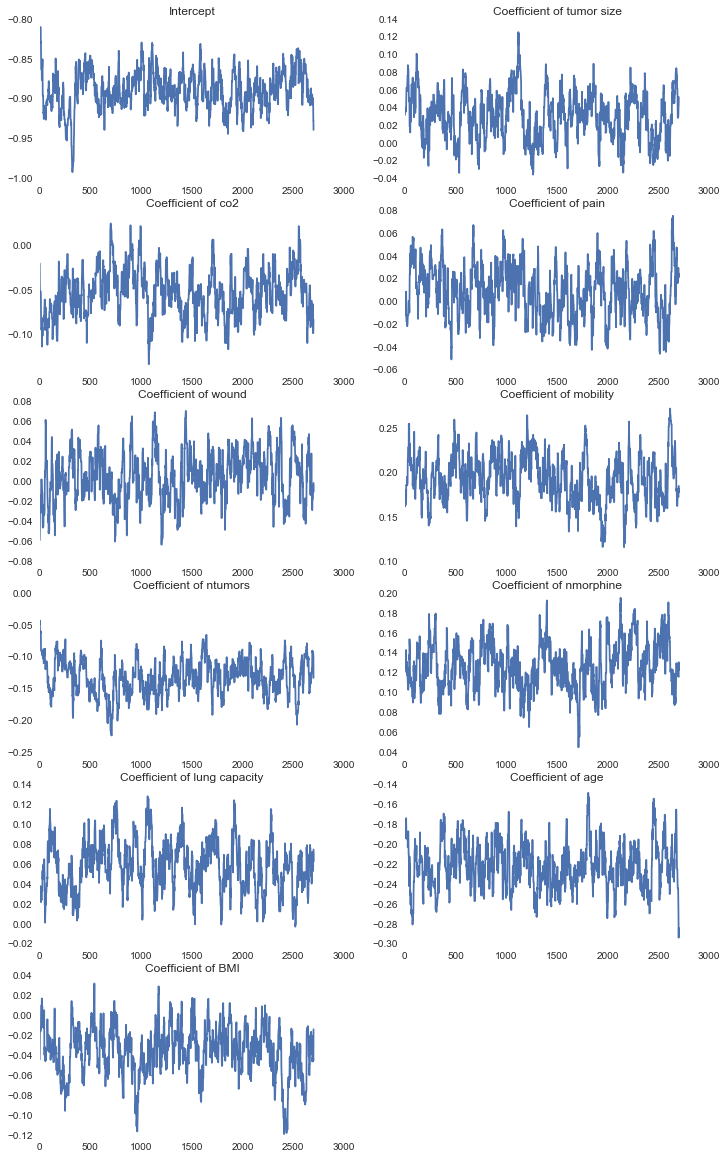

In [6]:
# Let us inspect the coefficients now
print coeffs.shape
print coeffs[coeffs.shape[0]-1,]
f, axarr = plt.subplots(6,2)
f.patch.set_facecolor('white')
f.set_size_inches(12,20)
axarr[0,0].plot(range(0,coeffs.shape[0]),coeffs[:,0])
axarr[0,0].set_title('Intercept')
axarr[0,1].plot(range(0,coeffs.shape[0]),coeffs[:,1])
axarr[0,1].set_title('Coefficient of tumor size')
axarr[1,0].plot(range(0,coeffs.shape[0]),coeffs[:,2])
axarr[1,0].set_title('Coefficient of co2')
axarr[1,1].plot(range(0,coeffs.shape[0]),coeffs[:,3])
axarr[1,1].set_title('Coefficient of pain')
axarr[2,0].plot(range(0,coeffs.shape[0]),coeffs[:,4])
axarr[2,0].set_title('Coefficient of wound')
axarr[2,1].plot(range(0,coeffs.shape[0]),coeffs[:,5])
axarr[2,1].set_title('Coefficient of mobility')
axarr[3,0].plot(range(0,coeffs.shape[0]),coeffs[:,6])
axarr[3,0].set_title('Coefficient of ntumors')
axarr[3,1].plot(range(0,coeffs.shape[0]),coeffs[:,7])
axarr[3,1].set_title('Coefficient of nmorphine')
axarr[4,0].plot(range(0,coeffs.shape[0]),coeffs[:,8])
axarr[4,0].set_title('Coefficient of lung capacity')
axarr[4,1].plot(range(0,coeffs.shape[0]),coeffs[:,9])
axarr[4,1].set_title('Coefficient of age')
axarr[5,0].plot(range(0,coeffs.shape[0]),coeffs[:,10])
axarr[5,0].set_title('Coefficient of BMI')
axarr[5,1].axis('off')
plt.show()

#### Plot the Coefficient Density

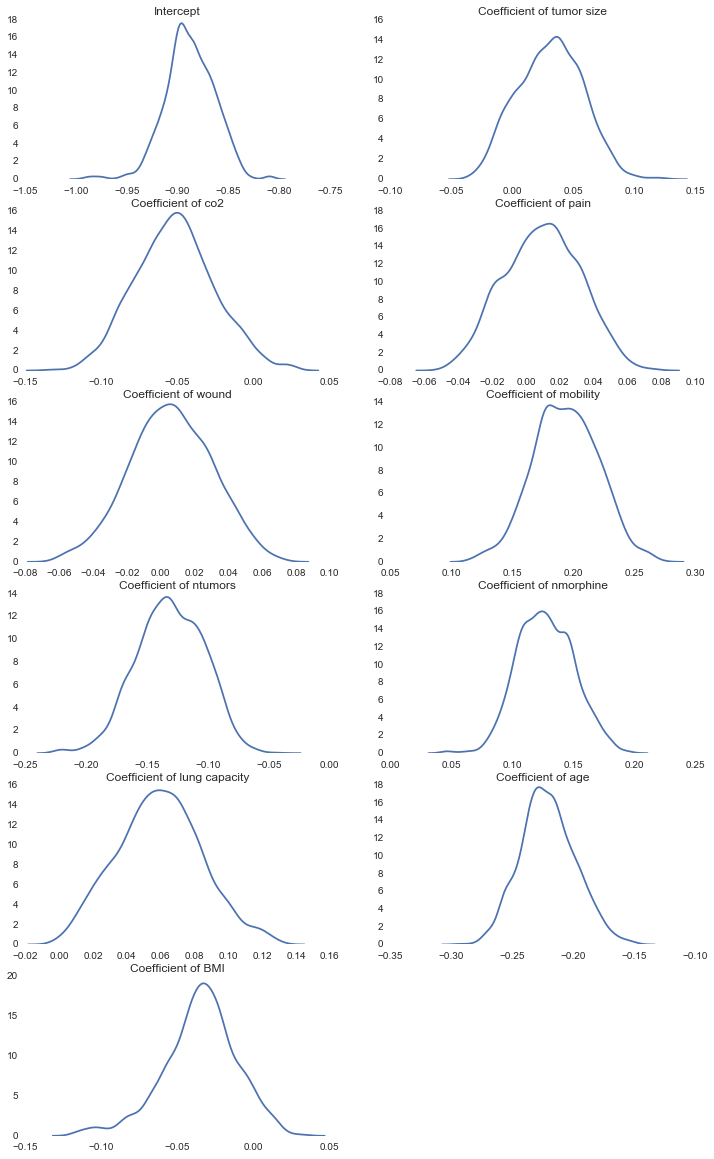

In [7]:
# Let us inspect the coefficients now
f, axarr = plt.subplots(6,2)
f.patch.set_facecolor('white')
f.set_size_inches(12,20)
sns.kdeplot(coeffs[:,0], ax=axarr[0,0])
axarr[0,0].set_title('Intercept')
sns.kdeplot(coeffs[:,1],ax=axarr[0,1])
axarr[0,1].set_title('Coefficient of tumor size')
sns.kdeplot(coeffs[:,2], ax=axarr[1,0])
axarr[1,0].set_title('Coefficient of co2')
sns.kdeplot(coeffs[:,3],ax=axarr[1,1])
axarr[1,1].set_title('Coefficient of pain')
sns.kdeplot(coeffs[:,4],ax=axarr[2,0])
axarr[2,0].set_title('Coefficient of wound')
sns.kdeplot(coeffs[:,5],ax=axarr[2,1])
axarr[2,1].set_title('Coefficient of mobility')
sns.kdeplot(coeffs[:,6],ax=axarr[3,0])
axarr[3,0].set_title('Coefficient of ntumors')
sns.kdeplot(coeffs[:,7],ax=axarr[3,1])
axarr[3,1].set_title('Coefficient of nmorphine')
sns.kdeplot(coeffs[:,8],ax=axarr[4,0])
axarr[4,0].set_title('Coefficient of lung capacity')
sns.kdeplot(coeffs[:,9],ax=axarr[4,1])
axarr[4,1].set_title('Coefficient of age')
sns.kdeplot(coeffs[:,10],ax=axarr[5,0])
axarr[5,0].set_title('Coefficient of BMI')
axarr[5,1].axis('off')
plt.show()

#### Inspect the mean and median of the coefficients

In [8]:
# What are the mean and median coeffs
beta_mean = np.mean(coeffs,axis=0)
beta_median = np.median(coeffs,axis=0)
print beta_mean
print beta_median

[-0.88786596  0.03107346 -0.05174167  0.00958957  0.00612892  0.19385902
 -0.13107353  0.12745026  0.05925101 -0.22078287 -0.03520514]
[-0.88854499  0.03199368 -0.05188614  0.00975286  0.00605003  0.19380677
 -0.13127726  0.12668915  0.05908674 -0.22182924 -0.03385624]


#### Let us now validate our code with R MCMCPack's MCMCLogit function

In [10]:
%load_ext rmagic

The rmagic extension is already loaded. To reload it, use:
  %reload_ext rmagic


In [12]:
%%R
library("MCMCpack")
R_df = read.csv(file="/Users/gmuralidhar/Projects/BayesianAnalysis/GibbsProbit/lung_cancer_remission.csv",head=TRUE,sep=",")
R_X = data.frame(
        R_df$tumorsize, 
        R_df$co2, 
        R_df$pain, 
        R_df$wound, 
        R_df$mobility, 
        R_df$ntumors, 
        R_df$nmorphine, 
        R_df$lungcapacity, 
        R_df$Age, 
        R_df$BMI
    )
R_X_std = scale(R_X)
R_data = data.frame(R_X_std,R_df$remission)
posterior = MCMClogit(
                R_data$R_df.remission~
                    R_data$R_df.tumorsize+
                    R_data$R_df.co2+
                    R_data$R_df.pain+
                    R_data$R_df.wound+
                    R_data$R_df.mobility+
                    R_data$R_df.ntumors+
                    R_data$R_df.nmorphine+
                    R_data$R_df.lungcapacity+
                    R_data$R_df.Age+
                    R_data$R_df.BMI, 
                data = R_data, 
                burnin = 300, 
                mcmc = 3000,
                thin = 1, 
                verbose = FALSE, 
                seed = NA, 
                beta.start = NA,
                b0 = 0, 
                B0 = 1, 
                bayes.resid = FALSE
            ) 
summary(posterior)


Iterations = 301:3300
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 3000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

                               Mean      SD  Naive SE Time-series SE
(Intercept)              -0.8939455 0.02355 0.0004300       0.003434
R_data$R_df.tumorsize     0.0324243 0.02663 0.0004861       0.003329
R_data$R_df.co2          -0.0559599 0.02782 0.0005079       0.003591
R_data$R_df.pain          0.0108015 0.02497 0.0004559       0.003232
R_data$R_df.wound         0.0003984 0.02695 0.0004921       0.003268
R_data$R_df.mobility      0.1978380 0.02789 0.0005091       0.003646
R_data$R_df.ntumors      -0.1321901 0.02680 0.0004893       0.003440
R_data$R_df.nmorphine     0.1378719 0.02471 0.0004511       0.003001
R_data$R_df.lungcapacity  0.0597875 0.02297 0.0004194       0.002570
R_data$R_df.Age          -0.2159274 0.02565 0.0004682       0.002963
R_data$R_df.BMI          -0.0385800 0.02613 0

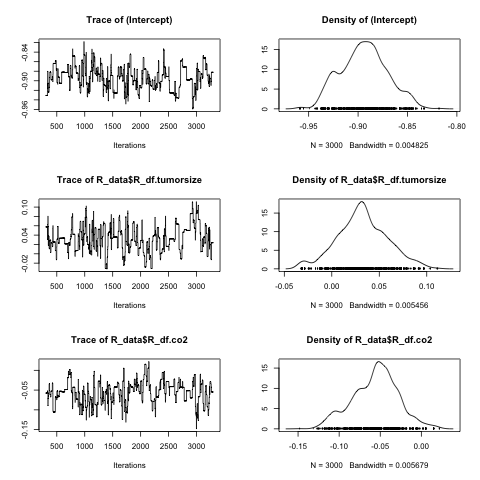

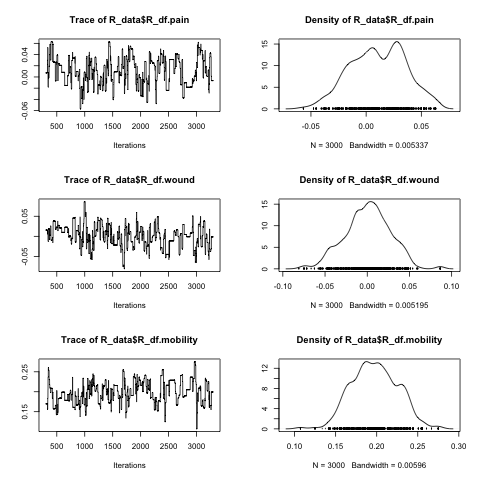

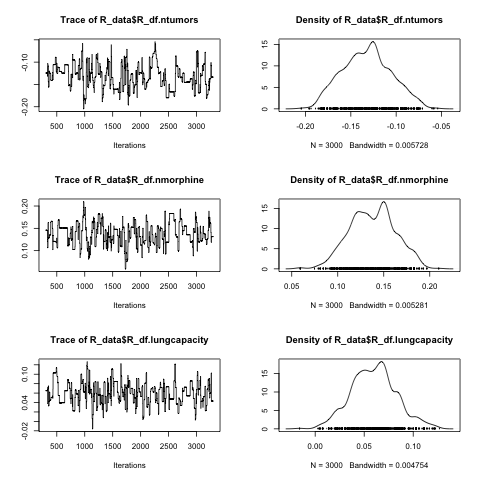

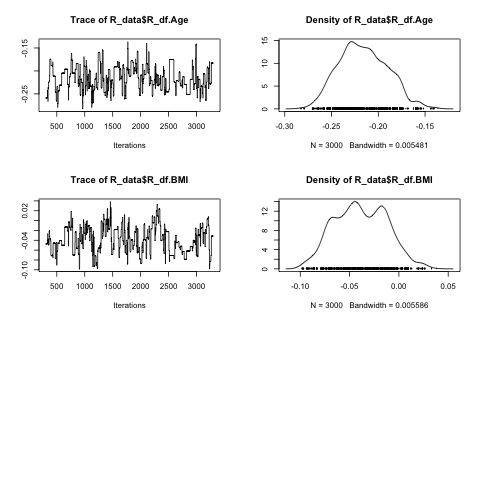

In [13]:
%R plot(posterior)